# Load libraries

In [2]:
import os
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch

from functools import partial
import concurrent.futures

# Constants

In [3]:
dataset = ('CAMELS_spat_NH', 'camels_spat')
countries = ["USA"]
# countries = ["CAN"]

# 'countries' to string and lowercase
countries_str = '-'.join(countries).lower()

NUM_BASINS = 2000
# StartDate = "1975-10-01"
# EndDate = "2019-09-30"
StartDate = "1980-10-01"
EndDate = "2008-09-30"

MULTIPROCESSING = 1

# Functions

In [4]:
def process_basin(basin, data_dir):
    df = pd.read_csv(os.path.join(data_dir, basin), index_col=0, parse_dates=True)   
    if df.index[0] <= pd.to_datetime(StartDate) and df.index[-1] >= pd.to_datetime(EndDate):
        
        # Create a Series of dates between the start and end date: 1 if date is present, 0 if missing
        date_range = pd.date_range(start=StartDate, end=EndDate, freq='D')
        # Filter df.index to ensure it's within the specified range
        filtered_index = df.index[(df.index >= StartDate) & (df.index <= EndDate)]
        # Create present_dates series with index filtered to within the range
        present_dates = pd.Series(1, index=filtered_index)
        # Create missing_dates series with index filtered to within the range
        missing_dates = pd.Series(0, index=date_range[~date_range.isin(filtered_index)])
        # Concatenate present_dates and missing_dates and sort by index
        date_presence = pd.concat([present_dates, missing_dates]).sort_index()
        
        # display(date_presence)
        
        # Check for missing days
        if df.index.freq != 'D':
            # Upsample to daily frequency
            df_daily = df.resample('D').mean()
            
            # Check for NaN values
            missing_days = df_daily.isnull().sum()
            if missing_days.any() > 0:  # Use any() method
                # print(f"Missing {missing_days.sum()} days found in {basin}")
                return basin, False, date_presence
        return basin, True, date_presence
    else:
        return basin, False, None
    
    
def plot_missing_data_heatmap(df, start_year, end_year, countries_str):
    
    fig, ax = plt.subplots(figsize=(30, 16))
    # Create a heatmap of the missing data with seaborn
    cmap = sns.mpl_palette("Set2", 2)
    sns.heatmap(df, cmap=cmap, cbar=False, ax=ax)
    
    legend_handles = [Patch(color=cmap[True], label='Non Missing Value'),  # red
                    Patch(color=cmap[False], label='Missing Value')]  # green
    plt.legend(handles=legend_handles, ncol=2, bbox_to_anchor=[0.5, 1.02], loc='lower center', fontsize=12, handlelength=1.2)
    plt.tight_layout()
    plt.show()

    # Save the figure
    fig.savefig(f"missing_data_{dataset[1]}_{start_year}-{end_year}_{countries_str}.png", dpi=300)

    
    

In [ ]:
# Load 531 basins as reference from 531_basin_file.txt (list of basins IDs)
lines = []
# Open the file in read mode
with open("531_basin_file.txt", 'r') as file:
    # Read each line and append it to the list
    for line in file:
        lines.append(line.strip())  # Remove any leading/trailing whitespace

# Print the lines to verify
basin531_ref = set(lines)

# Run

In [12]:
# Initialize lists to store basin information
selected_basins = []
df_basins_missing = pd.DataFrame()
counter = 0
counter_not_in_ref = 0
not_to_stop = True
for country in countries:
    data_dir = f"../../../../../gladwell/hydrology/SUMMA/summa-ml-models/{dataset[0]}/CAMELS_spat_{country}"
    basins = sorted(os.listdir(data_dir))
    
    if MULTIPROCESSING:
        with concurrent.futures.ProcessPoolExecutor() as executor:
            # Define a partial function to pass the data_dir
            process_basin_partial = partial(process_basin, data_dir=data_dir)
            
            # Process each basin concurrently
            results = [executor.submit(process_basin_partial, basin) for basin in basins]
            
            # Wait for all results to be available
            for result in concurrent.futures.as_completed(results):
                
                basin, basin_ok, date_presence = result.result()
                
                # Append date_presence to the dataframe
                if date_presence is not None:
                    # df_basins_missing[basin] = date_presence
                    # Create a DataFrame from the basin and date_presence
                    df_to_concat = pd.DataFrame({basin: date_presence})
                    # Concatenate the new DataFrame with df_basins_missing
                    df_basins_missing = pd.concat([df_basins_missing, df_to_concat], axis=1)
                    
                    # Check if the basin is in the reference list
                    basin_id = basin.split('_')[-1]
                    basin_id = basin_id.split('.')[0]
                    if basin_id not in basin531_ref:
                        # print(f"Basin {country}_{basin_id} not in the reference list (531)")
                        counter_not_in_ref  += 1
                
                if basin_ok:
                    # print(counter, basin_ok)
                    selected_basins.append(basin)
                    
                    counter += 1
                    if counter == NUM_BASINS:
                        break
                    
        print(country, len([res for res in results if res.result() is not None]), '->', len(selected_basins), \
            f'{counter_not_in_ref} not in 531')
        
    else:
        # Initialize lists to store basin information
        for basin in basins[:100]:
            # print(counter, basin)
            _, basin_ok, date_presence = process_basin(basin, data_dir)
            # print(basin_ok, date_presence)
            
            # Append date_presence to the dataframe
            if date_presence is not None:
                df_basins_missing[basin] = date_presence
            
            if basin_ok:
                print(counter, basin)
                selected_basins.append(basin)
                
                counter += 1
                if counter == NUM_BASINS:
                    break

Basin USA_01118300 not in the reference list (531)
Basin USA_01121000 not in the reference list (531)
Basin USA_01013500 not in the reference list (531)
Basin USA_01485500 not in the reference list (531)
Basin USA_01030500 not in the reference list (531)
Basin USA_01486000 not in the reference list (531)
Basin USA_01613050 not in the reference list (531)
Basin USA_02011460 not in the reference list (531)
Basin USA_01658500 not in the reference list (531)
Basin USA_01620500 not in the reference list (531)
Basin USA_02051000 not in the reference list (531)
Basin USA_02235200 not in the reference list (531)
Basin USA_02231342 not in the reference list (531)
Basin USA_02310947 not in the reference list (531)
Basin USA_02430615 not in the reference list (531)
Basin USA_02327100 not in the reference list (531)
Basin USA_02324400 not in the reference list (531)
Basin USA_02408540 not in the reference list (531)
Basin USA_02312200 not in the reference list (531)
Basin USA_02314500 not in the r

In [7]:
# print(df_basins_missing.head())
# print(df_basins_missing.tail())

df_basins_missing.shape

(10227, 609)

In [8]:
# Extract start and end years
start_year = pd.to_datetime(StartDate).year
end_year = pd.to_datetime(EndDate).year

# Write all selected basin names to a file named after the counter
with open(f"{len(selected_basins)}_basin_{dataset[1]}_{start_year}-{end_year}_{countries_str}.txt", "w") as f:
    for basin_name in sorted(selected_basins):
        f.write(basin_name.split('.')[0] + "\n")
    
    # Remove last newline character
    f.seek(f.tell() - 1)
    f.truncate()

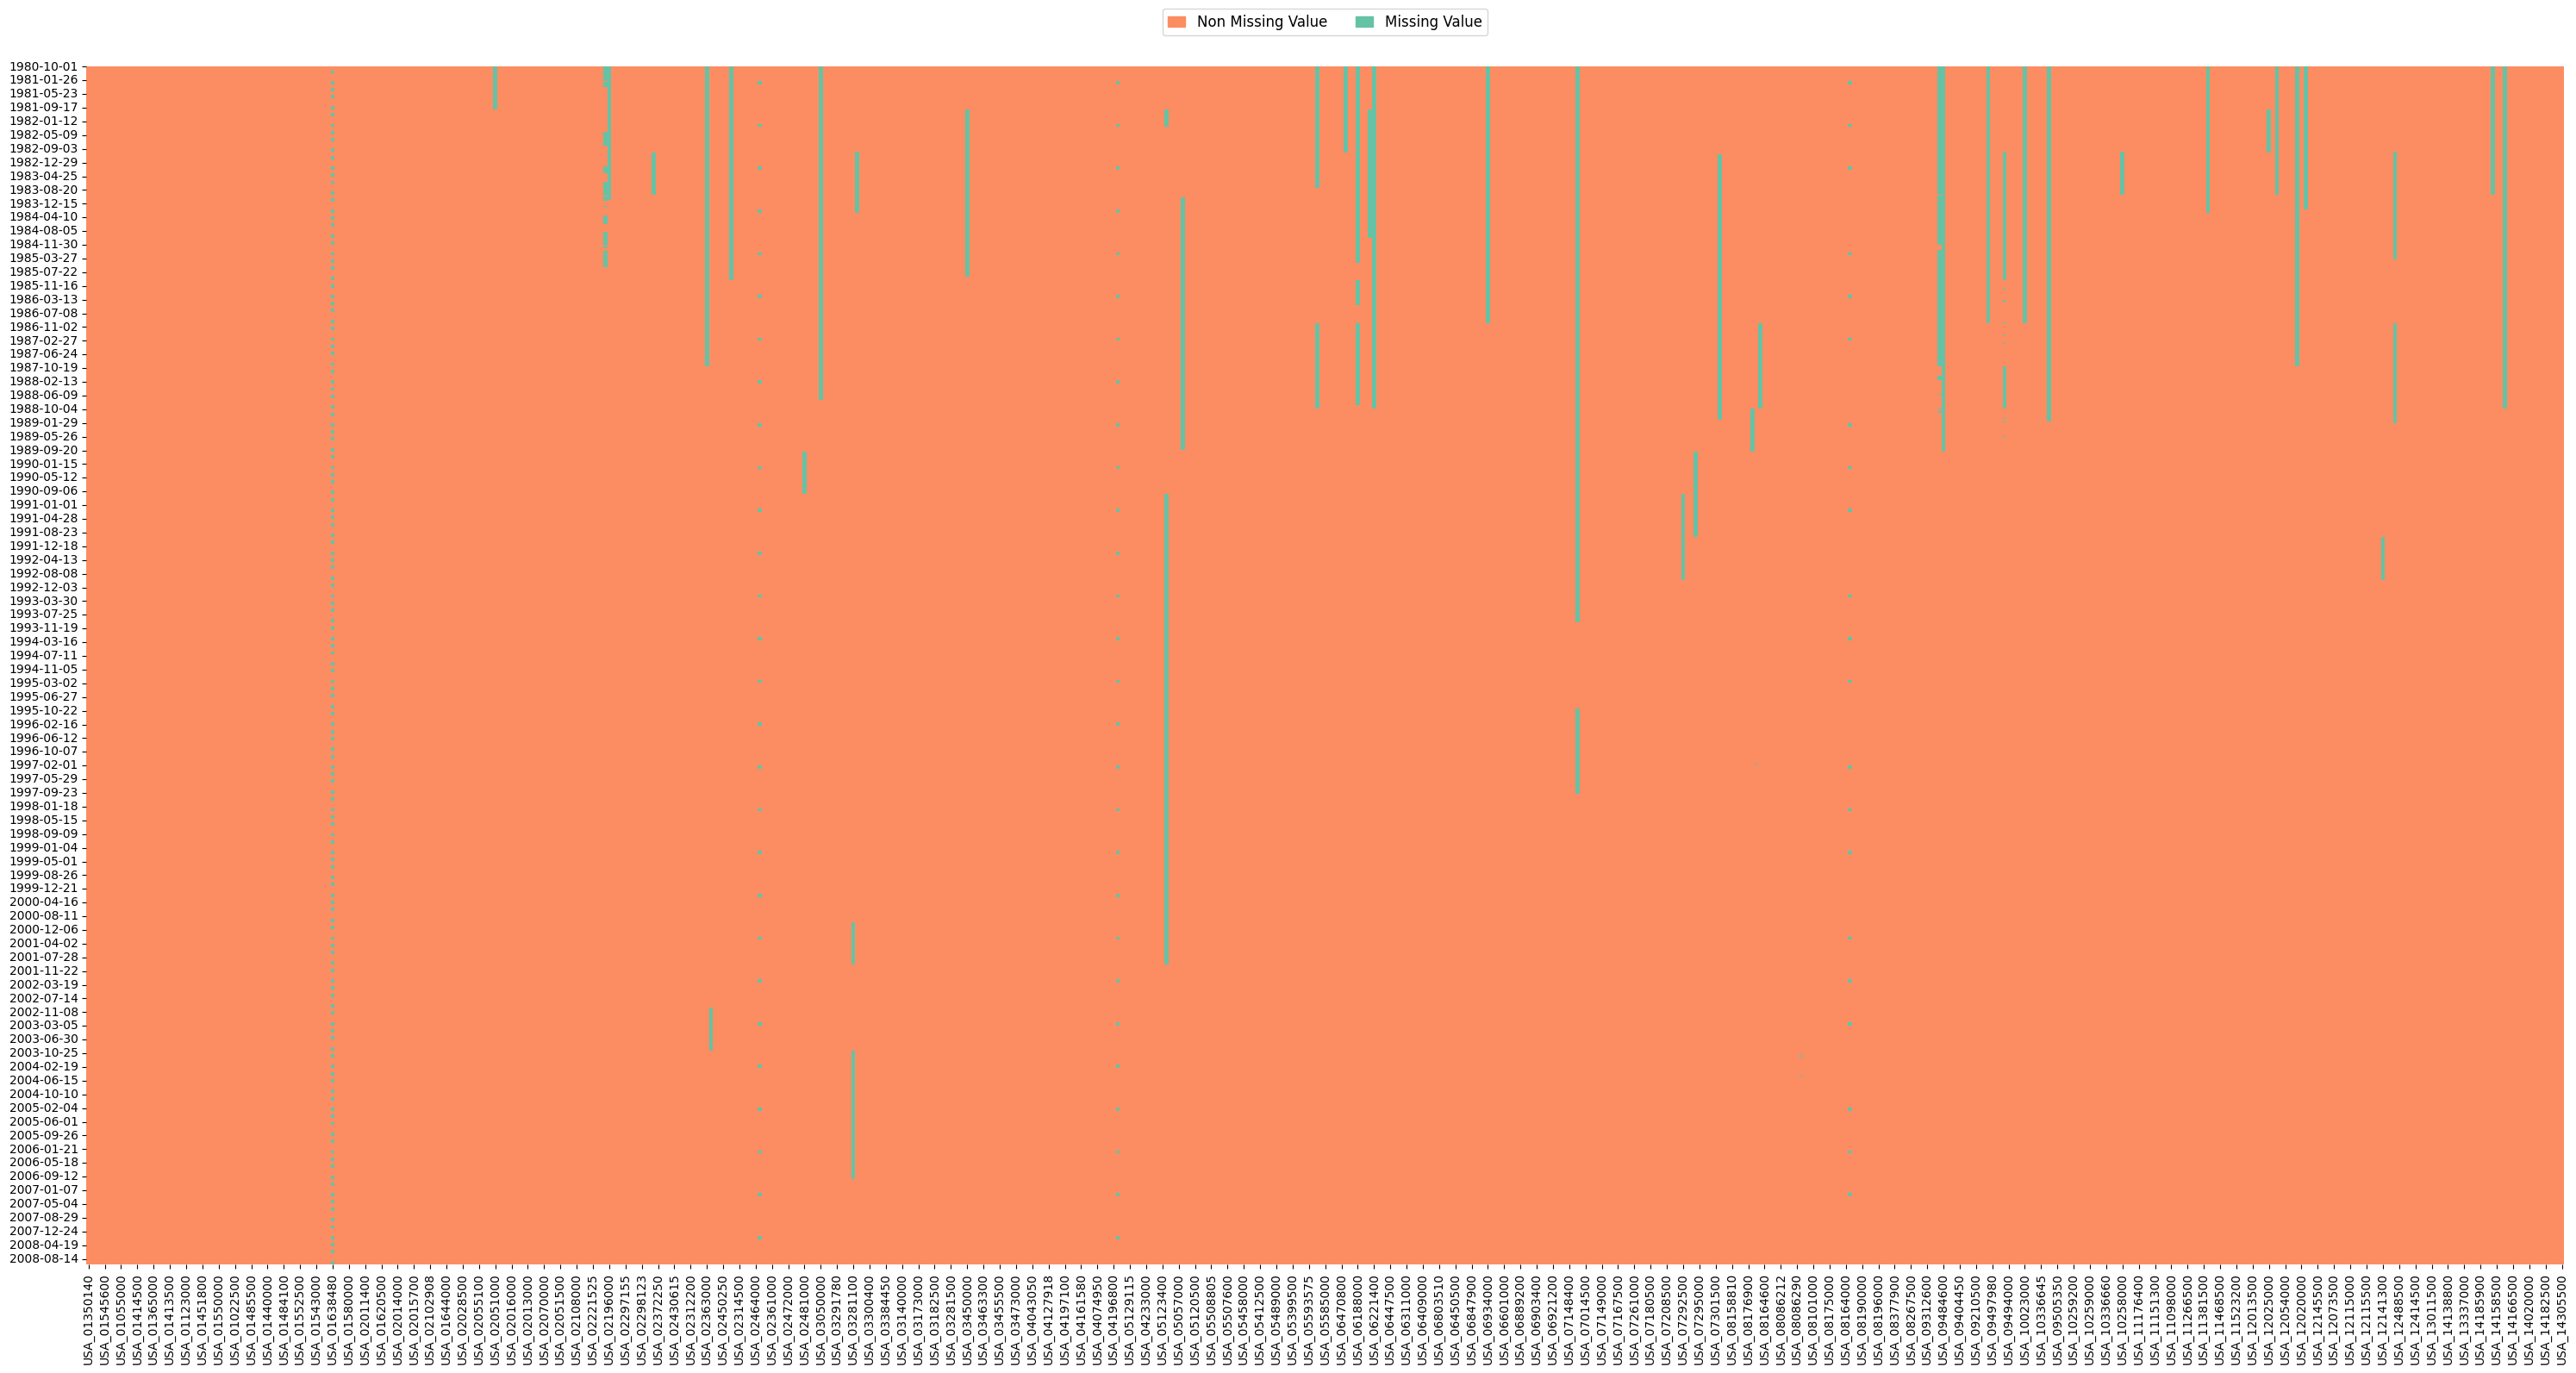

In [9]:
# Rename columns to remove file extension
df_basins_missing.columns = [col.split('.')[0] for col in df_basins_missing.columns]

# Date column to string format and YYYY-MM-DD if needed
if df_basins_missing.index.dtype == 'datetime64[ns]':
    df_basins_missing.index = df_basins_missing.index.strftime('%Y-%m-%d')

plot_missing_data_heatmap(df_basins_missing, start_year=start_year, end_year=end_year, countries_str=countries_str)

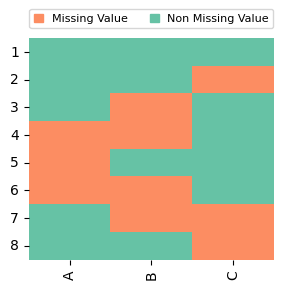

In [10]:
import pandas as pd
df = pd.DataFrame({'A': {1: False, 2: False, 3: False, 4: True, 5: True, 6: True, 7: False, 8: False},
                   'B': {1: False, 2: False, 3: True, 4: True, 5: False, 6: True, 7: True, 8: False},
                   'C': {1: False, 2: True, 3: False, 4: False, 5: False, 6: False, 7: True, 8: True}})
fig, ax = plt.subplots(figsize=(3, 3))
cmap = sns.mpl_palette("Set2", 2)
sns.heatmap(data=df, cmap=cmap, cbar=False)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
legend_handles = [Patch(color=cmap[True], label='Missing Value'),  # red
                  Patch(color=cmap[False], label='Non Missing Value')]  # green
plt.legend(handles=legend_handles, ncol=2, bbox_to_anchor=[0.5, 1.02], loc='lower center', fontsize=8, handlelength=.8)
plt.tight_layout()
plt.show()